
# DS3000 Final Project — Flood Detection from Satellite Imagery (SEN12FLOOD)

**Course:** DS3000 — Introduction to Machine Learning  
**Group 3**

**Members:**
- Raco Ahmed  
- Mohammed Sidahmed  
- Mikaail Sukkurwala  
- Tony Karunakkal  

**Goal:**  
Build and compare machine learning models (classical + deep learning) to classify satellite patches from the SEN12FLOOD dataset as **flooded** vs **non-flooded**, using Sentinel-2 optical bands (RGB).



In [5]:
# SECTION 1 — Imports & Config

import os
import json
import cv2
import random
from concurrent.futures import ThreadPoolExecutor

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_curve,
    auc
)
import joblib

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import load_model


# Global configuration

DATASET_PATH = '/content/drive/MyDrive/DS3000 Final Project/archive/SEN12FLOOD'
IMG_SIZE = 128
TARGET_COUNT = 1000          # Total image patches we aim to load (approx)
MODEL_SAVE_PATH = '/content/drive/MyDrive/DS3000 Final Project/models'

os.makedirs(MODEL_SAVE_PATH, exist_ok=True)

print("Dataset path:", DATASET_PATH)
print("Model save path:", MODEL_SAVE_PATH)


TensorFlow version: 2.19.0
Dataset path: /content/drive/MyDrive/DS3000 Final Project/archive/SEN12FLOOD
Model save path: /content/drive/MyDrive/DS3000 Final Project/models


In [6]:
# SECTION 2 — Data Loading (Balanced RGB set)

def scan_dataset_metadata(dataset_path):
    """
    Scan S2list.json to find all available image entries, split into:
      - flood_tasks: entries where FLOODING = True
      - non_flood_tasks: entries where FLOODING = False

    We don't load images here, just collect metadata for later.
    """
    print("Scanning metadata to find floods...")
    json_path = os.path.join(dataset_path, 'S2list.json')

    with open(json_path, 'r') as f:
        metadata = json.load(f)

    flood_tasks = []
    non_flood_tasks = []

    for key, value in metadata.items():
        # Folder names in the zip are often like "0001", "0063" etc.
        # Convert "0063" -> "63" safely.
        try:
            folder_name = str(int(key))
        except:
            folder_name = key

        folder_path = os.path.join(dataset_path, folder_name)

        # Skip if folder doesn't exist
        if not os.path.exists(folder_path):
            continue

        # Iterate through sub-entries (1, 2, 3, ...)
        for sub_key, info in value.items():
            if not isinstance(info, dict) or 'filename' not in info:
                continue

            task = (folder_path, info)

            if info.get('FLOODING', False):
                flood_tasks.append(task)
            else:
                non_flood_tasks.append(task)

    print(f"   Found {len(flood_tasks)} potential Flood patches")
    print(f"   Found {len(non_flood_tasks)} potential Non-Flood patches")
    return flood_tasks, non_flood_tasks


def process_image_task(task):
    """
    Load one Sentinel-2 RGB patch (B04, B03, B02) and return:
      - img_resized: (IMG_SIZE, IMG_SIZE, 3) normalized
      - label: 1 if flooded, 0 otherwise
    """
    folder_path, info = task
    base_filename = info['filename']
    label = 1 if info.get('FLOODING', False) else 0

    path_b2 = os.path.join(folder_path, f"{base_filename}_B02.tif")  # Blue
    path_b3 = os.path.join(folder_path, f"{base_filename}_B03.tif")  # Green
    path_b4 = os.path.join(folder_path, f"{base_filename}_B04.tif")  # Red

    try:
        b2 = cv2.imread(path_b2, cv2.IMREAD_UNCHANGED)
        b3 = cv2.imread(path_b3, cv2.IMREAD_UNCHANGED)
        b4 = cv2.imread(path_b4, cv2.IMREAD_UNCHANGED)

        if b2 is None or b3 is None or b4 is None:
            return None

        # Stack into RGB (R,G,B) and normalize
        img = np.dstack((b4, b3, b2)).astype('float32')
        img = img / (np.max(img) + 1e-6)
        img_resized = cv2.resize(img, (IMG_SIZE, IMG_SIZE))

        return (img_resized, label)
    except Exception as e:
        # Optionally print(e) for debugging
        return None


def load_balanced_dataset(dataset_path, target_count):
    """
    Build a roughly balanced dataset: ~50% flood, ~50% non-flood.
    Uses metadata from S2list.json, then loads images in parallel.
    """
    floods, non_floods = scan_dataset_metadata(dataset_path)

    if len(floods) == 0:
        print("CRITICAL: No flood labels found in JSON metadata.")
        return np.array([]), np.array([])

    # 50/50 split as much as possible
    samples_per_class = target_count // 2

    selected_floods = random.sample(floods, min(len(floods), samples_per_class))
    selected_non_floods = random.sample(non_floods, min(len(non_floods), samples_per_class))

    task_list = selected_floods + selected_non_floods
    random.shuffle(task_list)

    print(f"Loading {len(task_list)} images (balanced mix)...")

    images = []
    labels = []

    with ThreadPoolExecutor(max_workers=16) as executor:
        results = list(executor.map(process_image_task, task_list))

    for res in results:
        if res is not None:
            images.append(res[0])
            labels.append(res[1])

    X = np.array(images)
    y = np.array(labels)

    print("Finished loading.")
    print("X shape:", X.shape)
    print("y shape:", y.shape)
    print("Class counts: Flood =", np.sum(y == 1), ", Non-Flood =", np.sum(y == 0))
    return X, y


# ---- Execute data loading ----
X, y = load_balanced_dataset(DATASET_PATH, TARGET_COUNT)


Scanning metadata to find floods...
   Found 101 potential Flood patches
   Found 592 potential Non-Flood patches
Loading 601 images (balanced mix)...
Finished loading.
X shape: (417, 128, 128, 3)
y shape: (417,)
Class counts: Flood = 101 , Non-Flood = 316



SUCCESS: Data split created.
Training Shape: (333, 128, 128, 3)
Test Shape: (84, 128, 128, 3)
Class Balance (entire dataset): 101 Floods, 316 Non-Floods


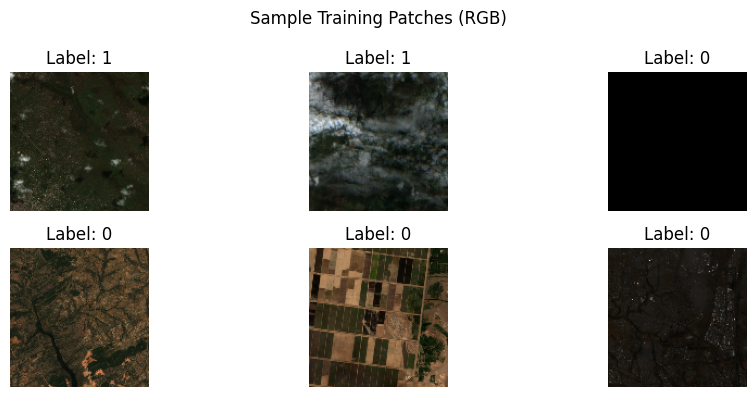

In [7]:
# SECTION 3 — Train/Test Split

if len(X) > 0:
    # Train/test split (80/20)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    print("\nSUCCESS: Data split created.")
    print(f"Training Shape: {X_train.shape}")
    print(f"Test Shape: {X_test.shape}")
    print(f"Class Balance (entire dataset): {np.sum(y==1)} Floods, {np.sum(y==0)} Non-Floods")

    # Quick sample visualization
    plt.figure(figsize=(10, 4))
    for i in range(6):
        if i >= len(X_train):
            break
        plt.subplot(2, 3, i+1)
        plt.imshow(X_train[i])
        plt.title(f"Label: {y_train[i]}")
        plt.axis('off')
    plt.suptitle("Sample Training Patches (RGB)")
    plt.tight_layout()
    plt.show()
else:
    print("Failed to load data. Please check dataset path and S2list.json.")


Flattening images for baseline models...

Training Logistic Regression...
Logistic Regression Accuracy: 0.7143
              precision    recall  f1-score   support

           0       0.77      0.89      0.83        64
           1       0.30      0.15      0.20        20

    accuracy                           0.71        84
   macro avg       0.54      0.52      0.51        84
weighted avg       0.66      0.71      0.68        84


Training KNN...
KNN Accuracy: 0.7619
              precision    recall  f1-score   support

           0       0.79      0.94      0.86        64
           1       0.50      0.20      0.29        20

    accuracy                           0.76        84
   macro avg       0.64      0.57      0.57        84
weighted avg       0.72      0.76      0.72        84


Training Decision Tree...
Decision Tree Accuracy: 0.7738
              precision    recall  f1-score   support

           0       0.83      0.89      0.86        64
           1       0.53      0

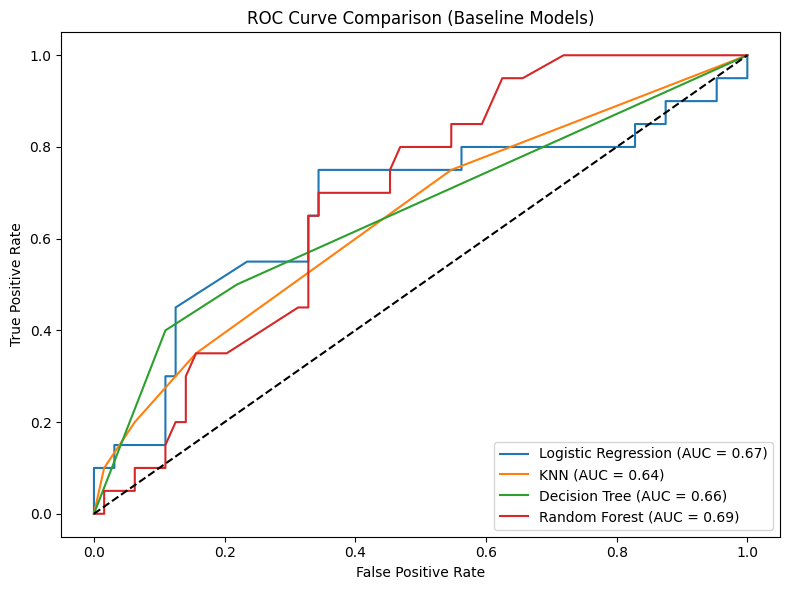

In [8]:
# SECTION 4 — Classical Baseline Models
#   - Logistic Regression
#   - KNN
#   - Decision Tree
#   - Random Forest

def train_eval_baselines(X_train, y_train, X_test, y_test):
    print("Flattening images for baseline models...")
    # Flatten 128x128x3 images into 1D vectors (49152 features)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)
    X_test_flat = X_test.reshape(X_test.shape[0], -1)

    models = {
        "Logistic Regression": LogisticRegression(max_iter=500),
        "KNN": KNeighborsClassifier(n_neighbors=5),
        "Decision Tree": DecisionTreeClassifier(),
        "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42)
    }

    plt.figure(figsize=(8, 6))  # For ROC Curve

    for name, model in models.items():
        print(f"\nTraining {name}...")
        model.fit(X_train_flat, y_train)

        # Save the model
        filename = os.path.join(MODEL_SAVE_PATH, f"{name.replace(' ', '_')}.joblib")
        joblib.dump(model, filename)

        # Predictions
        preds = model.predict(X_test_flat)
        probs = model.predict_proba(X_test_flat)[:, 1]  # For ROC

        # Metrics
        acc = accuracy_score(y_test, preds)
        print(f"{name} Accuracy: {acc:.4f}")
        print(classification_report(y_test, preds))

        # ROC Curve
        fpr, tpr, _ = roc_curve(y_test, probs)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

    # Finalize ROC Plot
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve Comparison (Baseline Models)')
    plt.legend(loc="lower right")
    plt.tight_layout()
    plt.show()

# ---- Execute ----
if len(X) > 0:
    train_eval_baselines(X_train, y_train, X_test, y_test)



Training Multi-Layer Perceptron (MLP)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Fitting MLP...
Epoch 1/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 80ms/step - accuracy: 0.6812 - loss: 1.9381
Epoch 2/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6933 - loss: 1.0356
Epoch 3/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.7706 - loss: 0.5755
Epoch 4/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7534 - loss: 0.7635
Epoch 5/5
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8036 - loss: 0.5396 


MLP Accuracy on Test: 0.7619
MLP Model saved to /content/drive/MyDrive/DS3000 Final Project/models/MLP_Model.h5


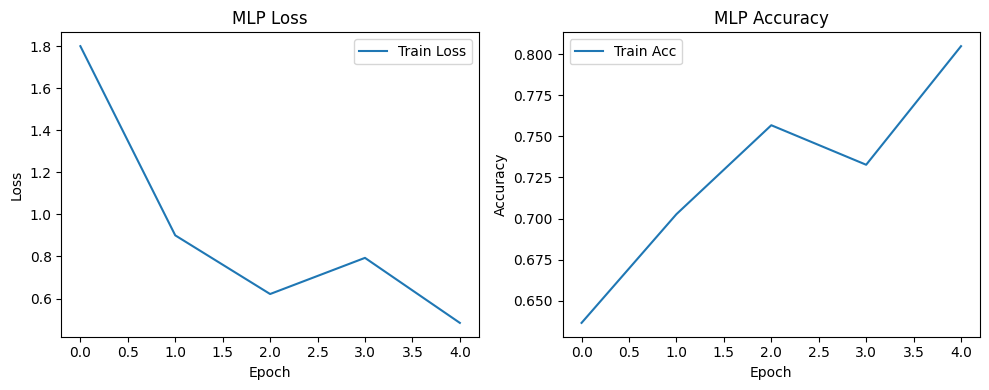

In [9]:
# SECTION 5 — MLP

def train_mlp_model(X_train, y_train, X_test, y_test):
    print("\nTraining Multi-Layer Perceptron (MLP)...")

    model = models.Sequential([
        layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid')   # Flood probability
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    print("Fitting MLP...")
    history = model.fit(X_train, y_train, epochs=5, batch_size=32, verbose=1)

    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"MLP Accuracy on Test: {acc:.4f}")

    # Save model
    mlp_path = os.path.join(MODEL_SAVE_PATH, 'MLP_Model.h5')
    model.save(mlp_path)
    print(f"MLP Model saved to {mlp_path}")

    # Plot training curves
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.title('MLP Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.title('MLP Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.tight_layout()
    plt.show()

# ---- Execute ----
if len(X) > 0:
    train_mlp_model(X_train, y_train, X_test, y_test)



Building Convolutional Neural Network (CNN)...
Training CNN (10 epochs)...


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 12s 557ms/step - accuracy: 0.7362 - loss: 0.6292 - precision: 0.2500 - recall: 0.0718 - val_accuracy: 0.7619 - val_loss: 0.5401 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 2/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.7579 - loss: 0.5321 - precision: 0.0000e+00 - recall: 0.0000e+00 - val_accuracy: 0.7619 - val_loss: 0.5122 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 3/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7514 - loss: 0.5099 - precision: 0.1111 - recall: 0.0052 - val_accuracy: 0.7857 - val_loss: 0.5067 - val_precision: 1.0000 - val_recall: 0.1000
Epoch 4/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.7682 - loss: 0.5161 - precision: 0.9271 - recall: 0.1351 - val_accuracy: 0.7619 - val_loss: 0.4932 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00
Epoch 5/10
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.7775 - loss: 0.4595 - precision: 0.6428 - recall: 0.0924 - val_ac

CNN Model saved to /content/drive/MyDrive/DS3000 Final Project/models/CNN_Model.h5


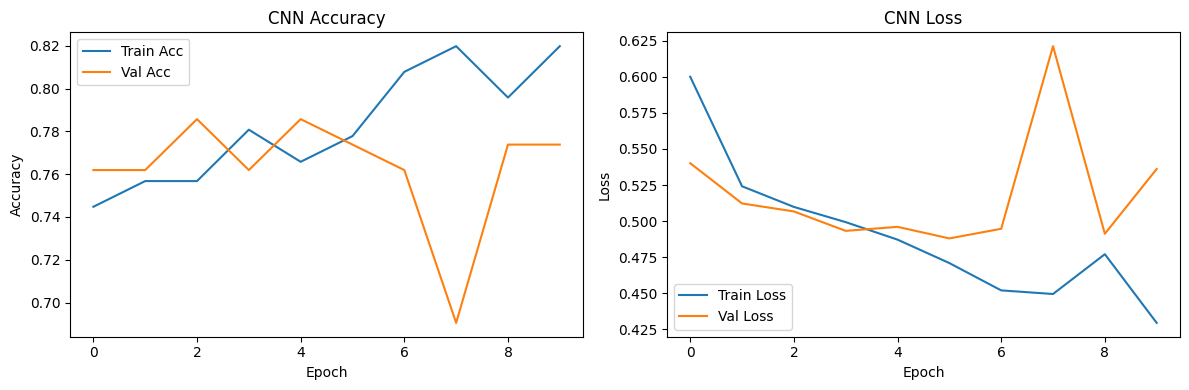

In [10]:
# SECTION 6 — CNN (Spatial Deep Model)

def build_and_train_cnn(X_train, y_train, X_test, y_test):
    print("\nBuilding Convolutional Neural Network (CNN)...")

    model = models.Sequential([
        # Convolutional Block 1
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional Block 3
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Dense Layers
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')   # Binary output
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy', tf.keras.metrics.Precision(name="precision"), tf.keras.metrics.Recall(name="recall")]
    )

    print("Training CNN (10 epochs)...")
    history = model.fit(
        X_train, y_train,
        epochs=10,
        batch_size=32,
        validation_data=(X_test, y_test),
        verbose=1
    )

    # Save model
    cnn_path = os.path.join(MODEL_SAVE_PATH, 'CNN_Model.h5')
    model.save(cnn_path)
    print(f"CNN Model saved to {cnn_path}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title('CNN Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('CNN Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# ---- Execute ----
if len(X) > 0:
    build_and_train_cnn(X_train, y_train, X_test, y_test)


Generating Deep Learning Metrics Report...

Loading & Testing MLP Model...


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step

--- MLP Classification Report ---
              precision    recall  f1-score   support

           0       0.81      0.89      0.85        64
           1       0.50      0.35      0.41        20

    accuracy                           0.76        84
   macro avg       0.66      0.62      0.63        84
weighted avg       0.74      0.76      0.75        84



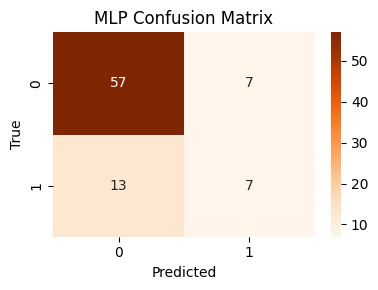


Loading & Testing CNN Model...


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 196ms/step

--- CNN Classification Report ---
              precision    recall  f1-score   support

           0       0.79      0.95      0.87        64
           1       0.57      0.20      0.30        20

    accuracy                           0.77        84
   macro avg       0.68      0.58      0.58        84
weighted avg       0.74      0.77      0.73        84



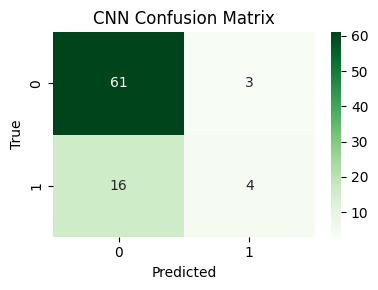

In [11]:
# SECTION 7 — Deep Models: Classification Reports & Confusion Matrices

def evaluate_deep_learning_models(X_test, y_test):
    print("Generating Deep Learning Metrics Report...\n")

    # --- 1. MLP ---
    mlp_path = os.path.join(MODEL_SAVE_PATH, 'MLP_Model.h5')
    if os.path.exists(mlp_path):
        print("Loading & Testing MLP Model...")
        mlp_model = load_model(mlp_path)
        y_pred_mlp = (mlp_model.predict(X_test).ravel() >= 0.5).astype(int)

        print("\n--- MLP Classification Report ---")
        print(classification_report(y_test, y_pred_mlp))

        plt.figure(figsize=(4, 3))
        sns.heatmap(confusion_matrix(y_test, y_pred_mlp), annot=True, fmt='d', cmap='Oranges')
        plt.title('MLP Confusion Matrix')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
    else:
        print("MLP model not found. Did you run the MLP training cell?")

    # --- 2. CNN ---
    cnn_path = os.path.join(MODEL_SAVE_PATH, 'CNN_Model.h5')
    if os.path.exists(cnn_path):
        print("\nLoading & Testing CNN Model...")
        cnn_model = load_model(cnn_path)
        y_pred_cnn = (cnn_model.predict(X_test).ravel() >= 0.5).astype(int)

        print("\n--- CNN Classification Report ---")
        print(classification_report(y_test, y_pred_cnn))

        plt.figure(figsize=(4, 3))
        sns.heatmap(confusion_matrix(y_test, y_pred_cnn), annot=True, fmt='d', cmap='Greens')
        plt.title('CNN Confusion Matrix')
        plt.xlabel("Predicted")
        plt.ylabel("True")
        plt.tight_layout()
        plt.show()
    else:
        print("CNN model not found. Did you run the CNN training cell?")

# ---- Execute ----
if 'X_test' in locals() and len(X_test) > 0:
    evaluate_deep_learning_models(X_test, y_test)
else:
    print("X_test is missing; re-run the data loading and splitting cells.")
